In [35]:
import numpy as np
import matplotlib.pyplot as plt

1.1.

In [36]:
data = np.genfromtxt('dailyweather.csv', delimiter=',', skip_header=1).T
t = np.linspace(0, len(data[0])-1, len(data[0]))
T = data[1]
h = data[2]
p = data[3]

In [37]:
def moving_average(window_size, data):
    pad_width = window_size // 2
    data_padded = np.pad(data, pad_width, mode='reflect')
    smoothed = np.convolve(data_padded, np.ones(window_size)/window_size, mode='valid')
    # If window size is even, cut off one extra
    if window_size % 2 == 0:
        smoothed = smoothed[:-1]
    return smoothed

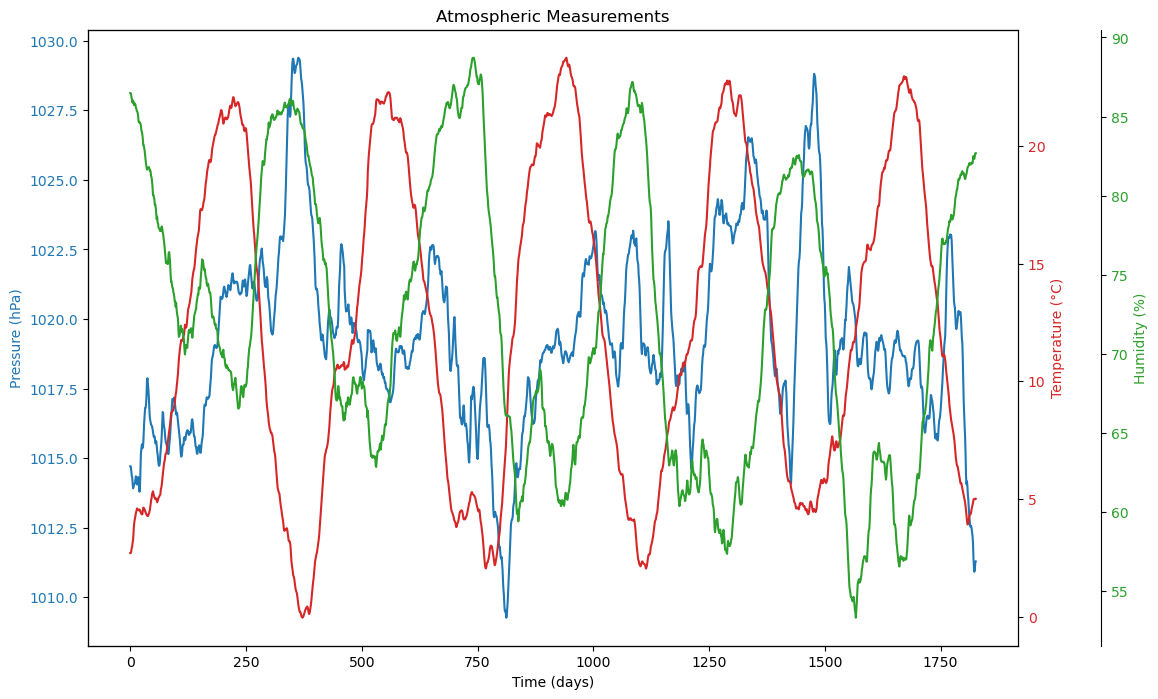

In [38]:
fig, ax1 = plt.subplots(figsize=(12, 8))
window_size = 50
lw = 1.5

# Plot pressure
color = 'tab:blue'
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Pressure (hPa)', color=color)
ax1.plot(t, moving_average(window_size, p), color=color, lw=lw)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for temperature
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(t, moving_average(window_size, T), color=color, lw=lw)
ax2.tick_params(axis='y', labelcolor=color)

# Create a third y-axis for humidity
ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Humidity (%)', color=color)
ax3.plot(t, moving_average(window_size, h), color=color, lw=lw)
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Atmospheric Measurements')
plt.show()

1.2.

Temperature and humidity definetly seem correlated. When the temperature is low humidity is very high and vice versa. This is because air can hold much more humidity when its warmer. So in winter the humidity is very high. So there is a strong correlation betweeen the two. 

The correlation between pressure and temperature as well as humidity is not that clearly visible. Generally pressure is lower when it is warmer. This is because warm air expands, which decreases density and therefore pressure. This is a weaker correlation. 

Physically, atmospheric pressure and humidity have an inverse relationship. As atmospheric pressure increases, humidity decreases because air tends to be denser so there is less room for moisture. However this is a weaker correlation and less visible in the plot. Temperature plays a more important role.

In [39]:
# Compute correlation coefficient
correlation_T_h = np.corrcoef(T, h)[0, 1]
correlation_T_p = np.corrcoef(T, p)[0, 1]
correlation_p_h = np.corrcoef(p, h)[0, 1]
print("Correlation temperature humidity:", correlation_T_h)
print("Correlation temperature pressure:", correlation_T_p)
print("Correlation temperature humidity:", correlation_p_h)

Correlation temperature humidity: -0.6034127296874737
Correlation temperature pressure: -0.01608885175163767
Correlation temperature humidity: -0.07274019167305061


The predictions were correct. All three pairs are inversely correlated. Temperature and humidity have a strong correlation. The other two pairs correlation is weaker.

1.3.

How will the return maps differ for different intervals? Expectation:

Temperature:  
1 day: Typically smaller spread  
30 days: Within 30 days, its still the same season, so values will be similar -> close to diagonal  
90 days: Jump across seasons, different temperatures -> big spread  
1 year: Same season again, similar temperatures -> close to diagonal  

Pressure:  
1 day: bigger spread than temperature  
30 days: Pressure changes fast, even in 30 day interval -> big spread  
90 days: Even more scattered -> very noisy  
1 year: Probably still quite scattered, maybe less than 90 day -> noisy  

Humidity:  
1 day: Typically smaller spread  
30 days: Still the same season, so similar values within one month -> close to diagonal  
90 days: Jump acriss seasons, large differences -> big spread  
1 year: Same season again, similar humidity, less similar than temperature -> relatively close to diagonal  

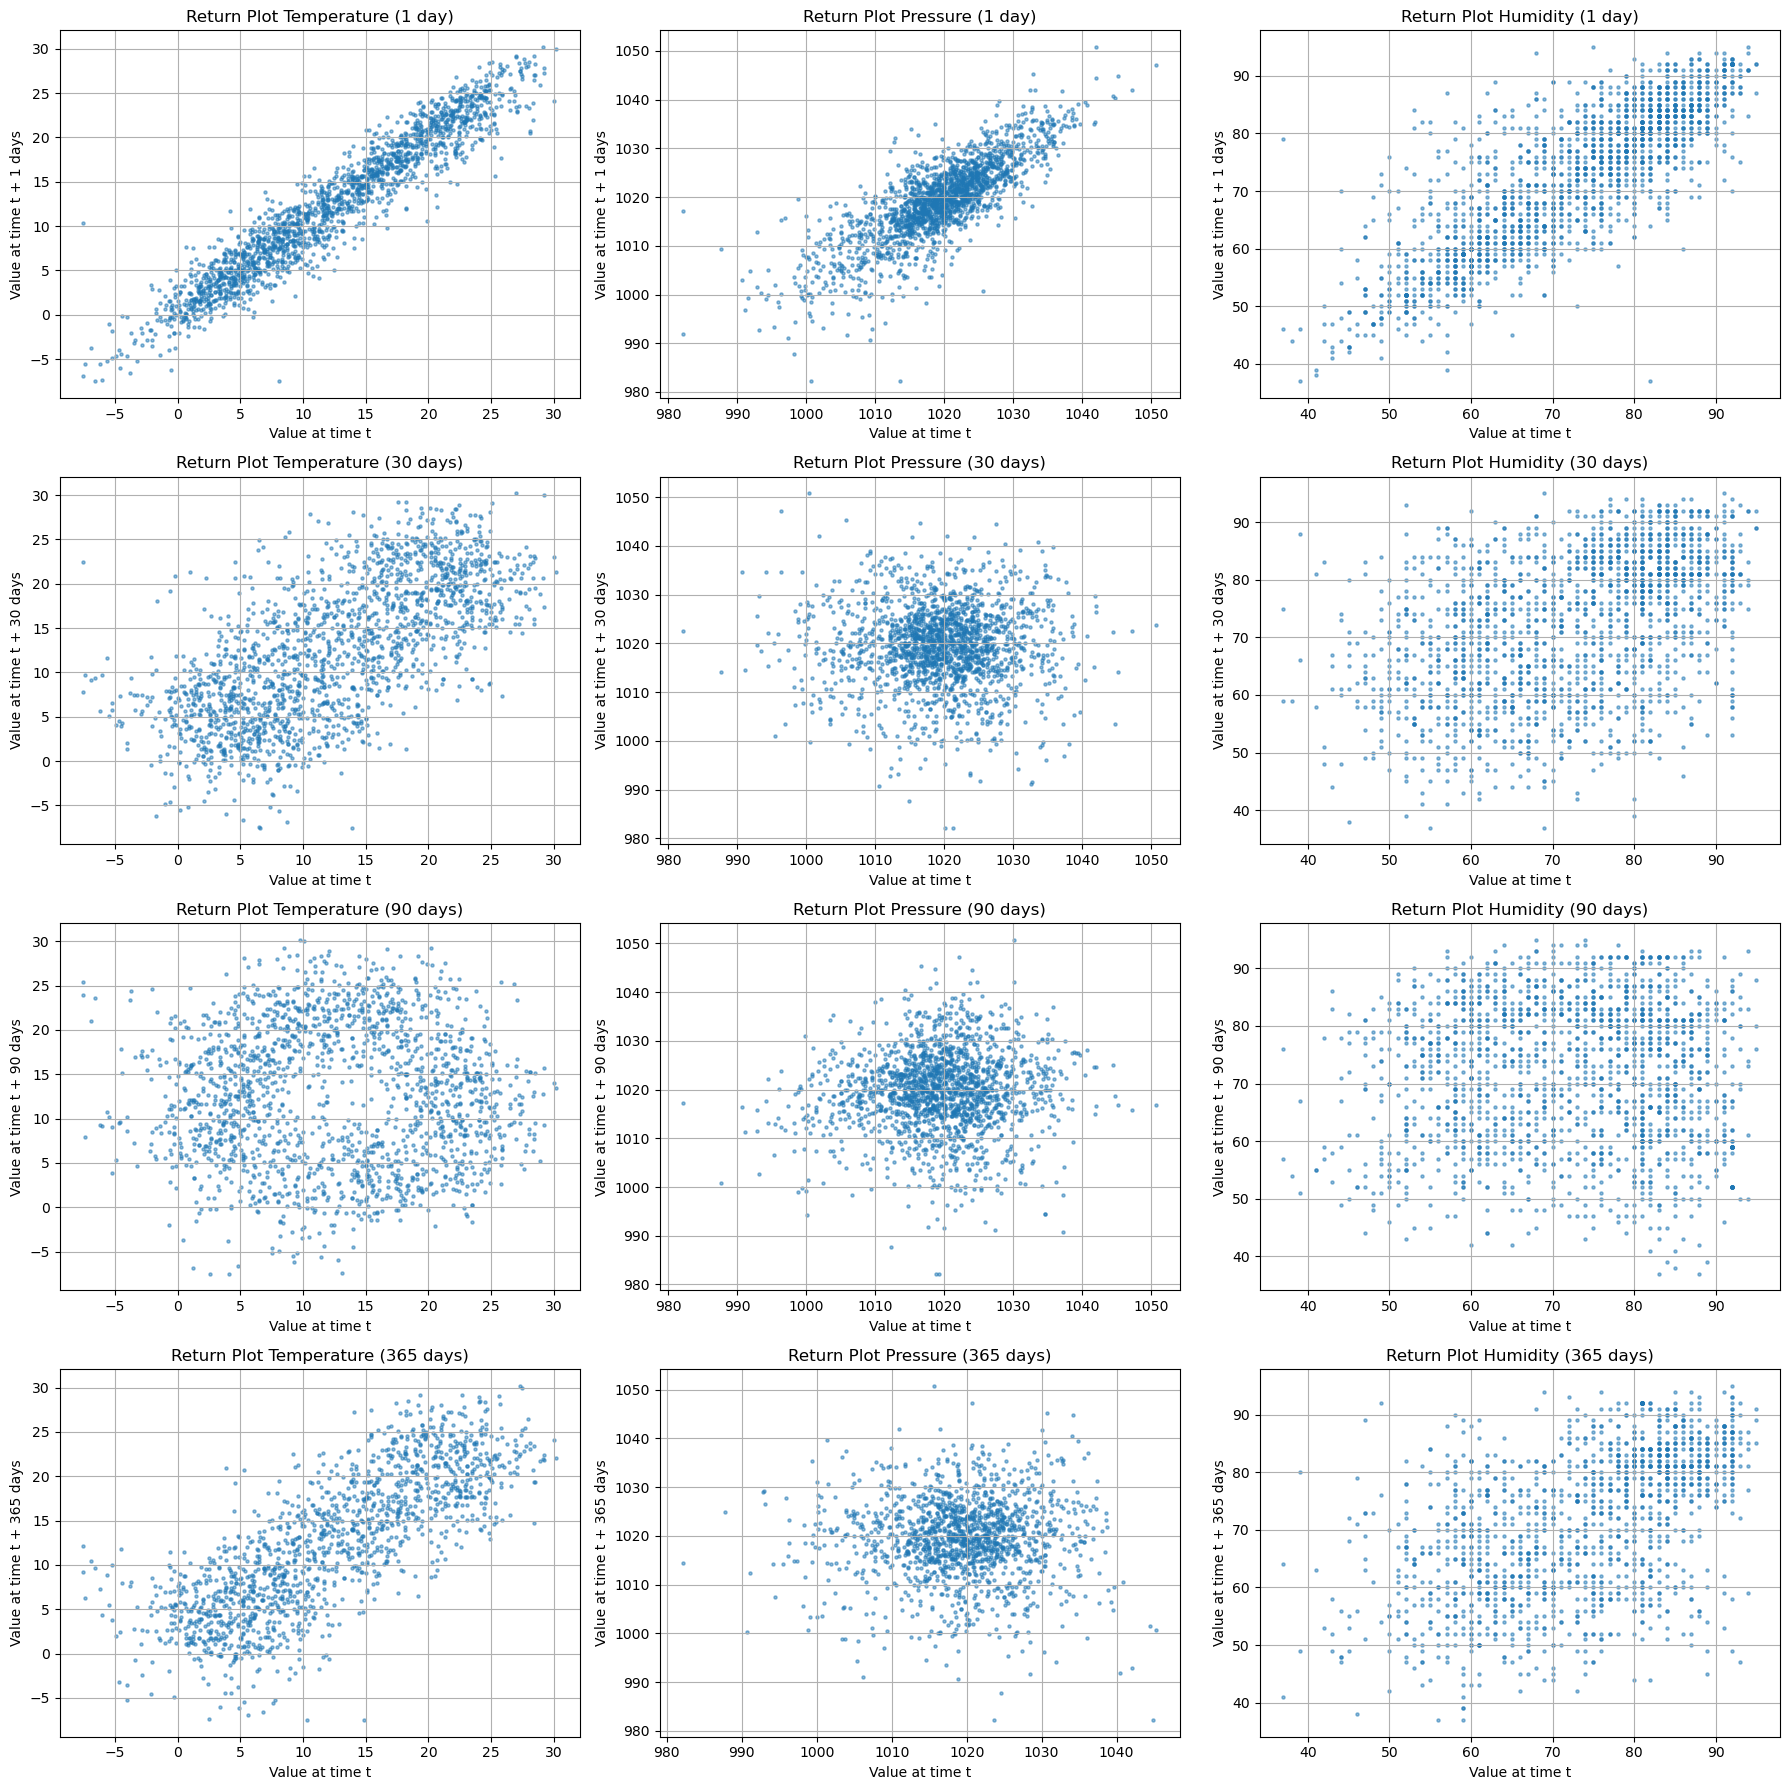

In [41]:
# Plot return plots

def create_return_plot(data, interval, ax, title):
    x = data[:-interval]
    y = data[interval:]
    ax.scatter(x, y, s=5, alpha=0.5)
    ax.set_xlabel(f"Value at time t")
    ax.set_ylabel(f"Value at time t + {interval} days")
    ax.set_title(title)
    ax.grid(True)

# Plotting for 30, 90, and 365 days
fig, axs = plt.subplots(4, 3, figsize=(18, 18))

create_return_plot(T, 1, axs[0, 0], "Return Plot Temperature (1 day)")
create_return_plot(T, 30, axs[1, 0], "Return Plot Temperature (30 days)")
create_return_plot(T, 90, axs[2, 0], "Return Plot Temperature (90 days)")
create_return_plot(T, 365, axs[3, 0], "Return Plot Temperature (365 days)")

create_return_plot(p, 1, axs[0, 1], "Return Plot Pressure (1 day)")
create_return_plot(p, 30, axs[1, 1], "Return Plot Pressure (30 days)")
create_return_plot(p, 90, axs[2, 1], "Return Plot Pressure (90 days)")
create_return_plot(p, 365, axs[3, 1], "Return Plot Pressure (365 days)")

create_return_plot(h, 1, axs[0, 2], "Return Plot Humidity (1 day)")
create_return_plot(h, 30, axs[1, 2], "Return Plot Humidity (30 days)")
create_return_plot(h, 90, axs[2, 2], "Return Plot Humidity (90 days)")
create_return_plot(h, 365, axs[3, 2], "Return Plot Humidity (365 days)")

plt.tight_layout()
plt.show()

The expectations are met. The variance in the pressure just seems smaller because of the scale.

1.4.

An upward trend in the temperature is not directly visible in the temperature return plot (365 days). 
To check if there is an upward trend one could use simple linear regression.

In [12]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(t, T)

print(f"Slope: {slope*365:.2f} °C/year")
print(f"P-value: {p_value:.4g}")

Slope: 0.39 °C/year
P-value: 0.002104


P is smaller than 0.05. So the trend is statistically significant. The linear regression shows, there is an upward trend in temperature.

Task 3

3.1.

In [30]:
def generate_ar_series(a0, a, T, init_vals, sigma=1.0):
    
    p = len(a)
    series = np.zeros(T)
    noise = np.random.normal(loc=0.0, scale=sigma, size=T)
    series[:p] = init_vals
    
    for t in range(p, T):
        series[t] = a0 + np.dot(a, series[t-p:t][::-1]) + noise[t]

    return series
    

In [31]:
T = 200
a0 = 0.0
a1 = -0.8
a2 = 0.0
a3 = 0.0
a4 = 0.4
a = np.array([a1, a2, a3, a4])
init_vals = np.array([0, 0, 0, 0])

series = generate_ar_series(a0, a, T, init_vals)

3.2.

Text(0, 0.5, 'time series')

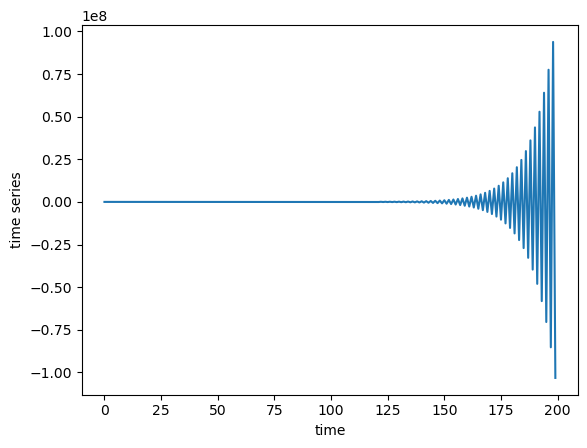

In [32]:
t = np.linspace(0, T-1, T)
plt.plot(t, series)
plt.xlabel('time')
plt.ylabel('time series')

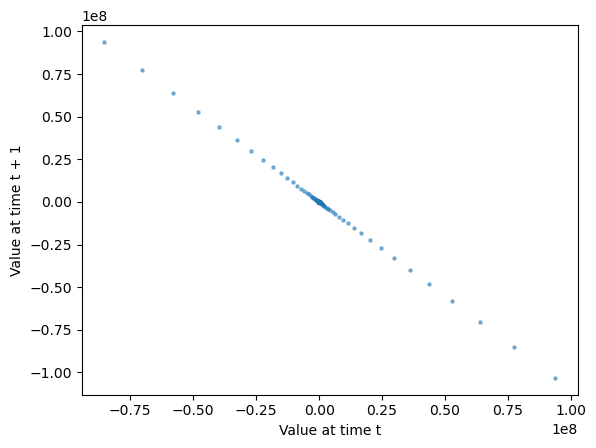

In [33]:
x = series[:-1]
y = series[1:]
plt.scatter(x, y, s=5, alpha=0.5)
plt.xlabel(f"Value at time t")
plt.ylabel(f"Value at time t + 1")
plt.show()

Most values are very close to the center of the return plot. So mostly the next value is very close to the current one. The center of the return plot is tightly packed. The values tend to return to a certain point.